<a href="https://colab.research.google.com/github/MohamadAshrafSalama/PyTorch-ImageSegmentation/blob/main/PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 3.9 MB/s 
     |████████████████████████████████| 58 kB 3.6 MB/s 
     |████████████████████████████████| 376 kB 27.9 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=a2ea528bfddc6d7a8adda21792fe02cb82f575eb63469e3e559d34a6e040f2a7
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=4979734023ad89684ba9c855b3876cdd03d2c412577bb9637bc15648dadc41fe
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 41.45 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [ ]:
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR='content'
DEVICE ='cuda'
EPOCHS=25
LR=0.003
IMAGE_SIZE=320
BATCH_SIZE=16
ENCODER='timm-efficientnet-b0'
WEIGHTS='imagenet'


In [ ]:
df=pd.read_csv(CSV_FILE)
df.head

<bound method NDFrame.head of                                                  masks  \
0    Human-Segmentation-Dataset-master/Ground_Truth...   
1    Human-Segmentation-Dataset-master/Ground_Truth...   
2    Human-Segmentation-Dataset-master/Ground_Truth...   
3    Human-Segmentation-Dataset-master/Ground_Truth...   
4    Human-Segmentation-Dataset-master/Ground_Truth...   
..                                                 ...   
285  Human-Segmentation-Dataset-master/Ground_Truth...   
286  Human-Segmentation-Dataset-master/Ground_Truth...   
287  Human-Segmentation-Dataset-master/Ground_Truth...   
288  Human-Segmentation-Dataset-master/Ground_Truth...   
289  Human-Segmentation-Dataset-master/Ground_Truth...   

                                                images  
0    Human-Segmentation-Dataset-master/Training_Ima...  
1    Human-Segmentation-Dataset-master/Training_Ima...  
2    Human-Segmentation-Dataset-master/Training_Ima...  
3    Human-Segmentation-Dataset-master/Traini

In [ ]:
row=df.iloc[6]

image_path=row.images
mask_path=row.masks

image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255

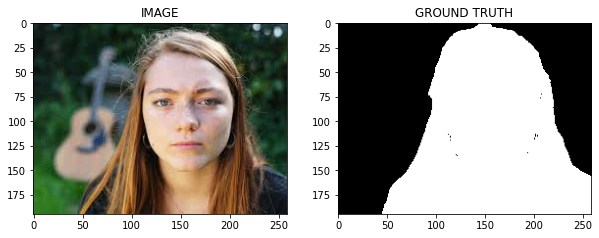

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=42)

In [ ]:
import albumentations as A

In [ ]:
from re import I
def get_train_aug():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_aug():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
     
  ])



In [ ]:
from torch.utils.data import Dataset

In [ ]:
class Segmentatio_data_set(Dataset):

  def __init__(self,df,augmentations):
      self.df=df
      self.augmentations=augmentations
    
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    
    row=self.df.iloc[idx]
    image=row.images
    mask_path=row.masks

    image=cv2.imread(image)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask=np.expand_dims(mask,axis=-1)

    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)
      image=data['image']
      mask=data['mask']

    image=np.transpose(image,(2,0,1)).astype(np.float32)
    mask=np.transpose(mask,(2,0,1)).astype(np.float32)

    image=torch.Tensor(image)/255.0
    mask=torch.round(torch.Tensor(mask)/255.0)
    
    return image, mask
  

    

In [ ]:
trainset=Segmentatio_data_set(train_df,get_train_aug())
validset=Segmentatio_data_set(valid_df,get_valid_aug())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


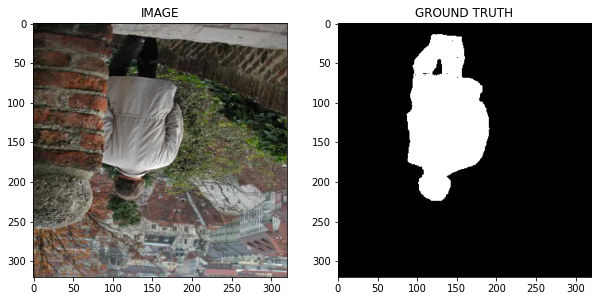

In [ ]:
idx=7
image,mask=trainset[idx]
helper.show_image(image,mask)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader=DataLoader(validset,batch_size=BATCH_SIZE)

In [ ]:
print(len(trainloader))
print(len(validloader))

15
4


In [ ]:
for image,mask in trainloader:
  break

print(image.shape,"mask",mask.shape)

torch.Size([16, 3, 320, 320]) mask torch.Size([16, 1, 320, 320])


In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss


In [ ]:
from pandas.core.dtypes.common import classes
class SegmentationModel(nn.Module):
  def __init__(self):

    super(SegmentationModel,self).__init__()

    self.arc=smp.Unet(encoder_name=ENCODER,encoder_weights=WEIGHTS  ,in_channels=3,classes=1,activation=None)


  def forward(self,images,masks=None):
    logits=self.arc(images)
    if mask !=None:
      loss1=DiceLoss(mode='binary')(logits,masks)
      loss2=nn.BCEWithLogitsLoss()(logits ,masks)
      return logits, loss2+loss2

    return logits


In [ ]:
model = SegmentationModel()
model.to(DEVICE);

In [ ]:
from torch._C import device
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss=0.0


  for images, masks in tqdm(data_loader):
    images=images.to(DEVICE)
    masks=masks.to(DEVICE)
  
  optimizer.zero_grad()


  logits, loss = model(images, masks)

  loss.backward()

  optimizer.step()
  total_loss+=loss.item()

  return total_loss/len(data_loader)

In [ ]:

def eval_fn(data_loader, model):
  model.eval()
  total_loss=0.0

  with torch.no_grad():


    for images, masks in tqdm(data_loader):
      images=images.to(DEVICE)
      masks=masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss+=loss.item()

  return total_loss/len(data_loader)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

In [ ]:

best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss= train_fn(trainloader, model,optimizer)
  valid_loss=eval_fn(validloader,model)

  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("Saved model")
    best_valid_loss=valid_loss


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Saved model


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Saved model


100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


Saved model


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Saved model


100%|██████████| 4/4 [00:00<00:00,  4.56it/s]


Saved model


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


Saved model


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


Saved model


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Saved model


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Saved model


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Saved model


100%|██████████| 4/4 [00:01<00:00,  3.45it/s]
